## Modello da applicare: Decision tree

Modelli con altri criteri sono risultati inefficienti a causa della bassa correlazione fra variabili quantitative come la popolazione per comune, o la data di inizio attività e la categoria di rischio

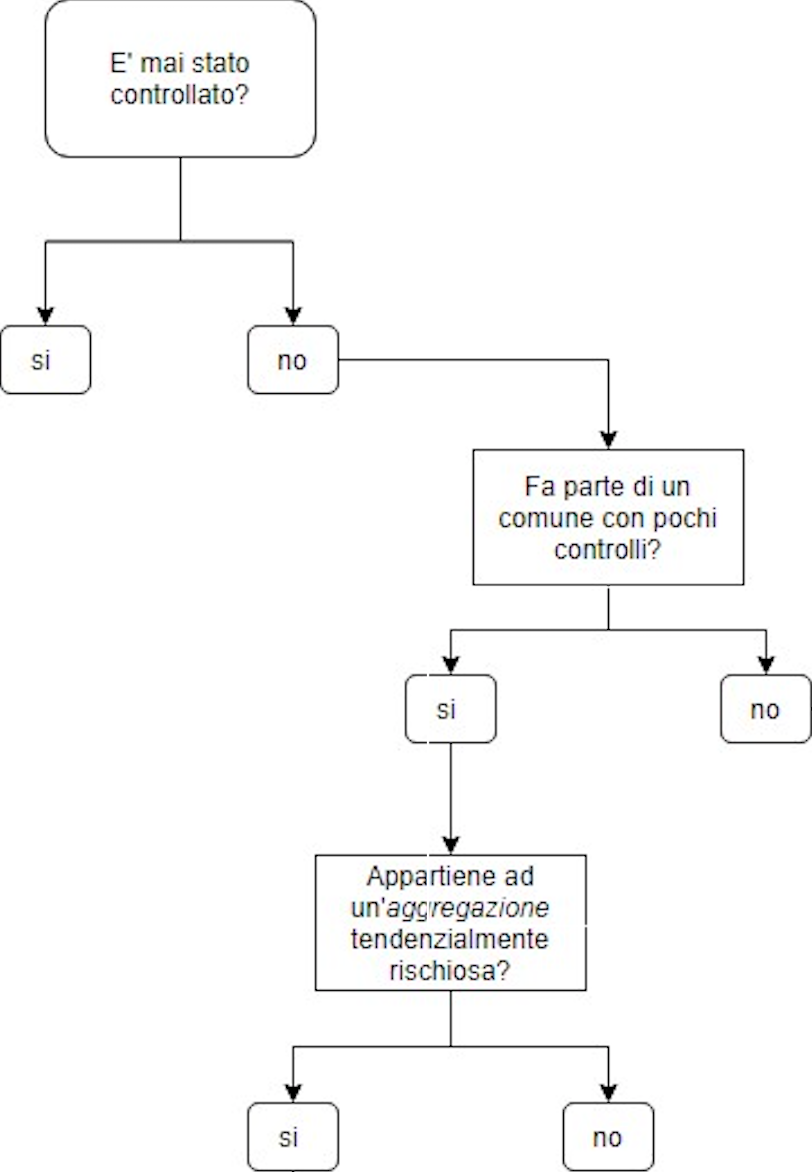

In [2]:
from IPython.display import Image
Image('/Users/francesco/Documents/gisa_dec_tree.png')

### Implementazione del decision tree:

### Prendiamo in considerazione stabilimenti mai controllati, che si trovano in comuni in cui meno del 20% degli stabilimenti è stato controllato almeno una volta e che appartengono ad aggregazioni con un rischio medio elevato.



In [3]:
from PIL import Image
import pandas as pd 
import psycopg2
import matplotlib.pyplot as plt
import numpy as np
import os

#### Definiamo le funzioni per connettersi ad un database PostgreSQL e per convertire le query in dataframe pandas:

In [4]:
def connect(params_dic):
    conn = None
    try:
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(**params_dic)
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        sys.exit(1) 
    print("Connection successful")
    return conn

def postgresql_to_dataframe(conn, select_query, column_names):
    cursor = conn.cursor()
    try:
        cursor.execute(select_query)
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        cursor.close()
        return 1
    
    # Otteniamo una lista di tuple
    tupples = cursor.fetchall()
    cursor.close()
    
    # Convertiamo la lista di tuple in un DataFrame pandas
    df = pd.DataFrame(tupples, columns=column_names)
    return df

#### Chiamiamo le funzioni:

In [5]:
param_dic = {
    "host"      : "localhost",
    "database"  : "gisa",
    "user"      : "postgres",
    "password"  : "12345"
}
col_names_ = ["id_stabilimento","comune","provincia_stab","macroarea","aggregazione","attivita","punteggio","categoria_rischio_stabilimento","categoria_assegnata_da_cu","categoria_ex_ante","popolazione","rischio_in_aumento","controllati","id_asl"]

conn_ = connect(param_dic)
df_gisa = postgresql_to_dataframe(conn_,"select * from gisa_completo",col_names_)

Connecting to the PostgreSQL database...
Connection successful


#### Data cleaning

In [6]:
df_gisa.categoria_assegnata_da_cu = df_gisa.categoria_assegnata_da_cu[df_gisa.categoria_assegnata_da_cu.isin([1,2,3,4,5,'1','2','3','4','5'])].astype(int)
df_gisa.rischio_in_aumento = df_gisa.rischio_in_aumento[df_gisa.rischio_in_aumento.isin([0,1])].astype(int)
df_gisa.controllati = df_gisa.controllati.astype(int)
df_gisa.id_asl = df_gisa.id_asl.replace(np.nan,0)
df_gisa.id_asl = df_gisa.id_asl.astype(int)

 #### Creazione di alcuni dataframe utili:
    - rapporto_contr_tot: per ogni comnune rapporto tra il numero di stabilimenti controllati e il numero di stabilimenti totali 
    
    - aggr_rischiose: lista di aggregazioni con una categoria di rischio media alta

In [7]:
rapporto_contr_tot = (df_gisa.loc[df_gisa.controllati == 1].groupby('comune').id_stabilimento.count() / df_gisa.groupby('comune').id_stabilimento.count()).sort_values()
rapporto_contr_tot.replace(np.nan,1)
comuni_rischiosi = list(rapporto_contr_tot[rapporto_contr_tot <= 0.2].keys())
aggr_rischiose = df_gisa[(df_gisa.rischio_in_aumento == 1 )].groupby(by='aggregazione').categoria_assegnata_da_cu.mean()
aggr_rischiose = list(aggr_rischiose[aggr_rischiose > 3].keys())

#### Creazione del dataset contenente solo gli stabilimenti che rispettano i criteri del decision tree:

In [8]:
filter_ = (df_gisa.controllati == 0) & (df_gisa.aggregazione.isin(aggr_rischiose)) & (df_gisa.comune.isin(comuni_rischiosi))
da_controllare = df_gisa[filter_]

#### Raggruppiamo gli id_stabilimenti per asl

In [9]:
df_gisa.id_stabilimento = df_gisa.id_stabilimento.astype(int)
asl_201 = da_controllare.loc[da_controllare.id_asl == 201].id_stabilimento.drop_duplicates(keep='first').unique()
asl_202 = da_controllare.loc[da_controllare.id_asl == 202].id_stabilimento.drop_duplicates(keep='first').unique()
asl_203 = da_controllare.loc[da_controllare.id_asl == 203].id_stabilimento.drop_duplicates(keep='first').unique()
asl_204 = da_controllare.loc[da_controllare.id_asl == 204].id_stabilimento.drop_duplicates(keep='first').unique()
asl_205 = da_controllare.loc[da_controllare.id_asl == 205].id_stabilimento.drop_duplicates(keep='first').unique()
asl_206 = da_controllare.loc[da_controllare.id_asl == 206].id_stabilimento.drop_duplicates(keep='first').unique()
asl_207 = da_controllare.loc[da_controllare.id_asl == 207].id_stabilimento.drop_duplicates(keep='first').unique()

asl_201 = pd.Series(asl_201)
asl_202 = pd.Series(asl_202)
asl_203 = pd.Series(asl_203)
asl_204 = pd.Series(asl_204)
asl_205 = pd.Series(asl_205)
asl_206 = pd.Series(asl_206)
asl_207 = pd.Series(asl_207)

#### Creazione della cartella "id_stab_da_controllare" con i file csv degli id da controllare divisi per asl:

In [10]:
path =os.path.join(os.getcwd(),"id_stab_da_controllare") 
if not os.path.exists(path):
    os.mkdir(path)

asl_201.to_csv(os.path.join(path,r'asl_201.csv'),index=False)
asl_202.to_csv(os.path.join(path,r'asl_202.csv'),index=False)
asl_203.to_csv(os.path.join(path,r'asl_203.csv'),index=False)
asl_204.to_csv(os.path.join(path,r'asl_204.csv'),index=False)
asl_205.to_csv(os.path.join(path,r'asl_205.csv'),index=False)
asl_206.to_csv(os.path.join(path,r'asl_206.csv'),index=False)
asl_207.to_csv(os.path.join(path,r'asl_207.csv'),index=False)